#### Nama : Angello Khara Sitanggang
#### NPM  : 220711833
#### Kelompok SB : Transformer
#### Arsitektur : MobileNet


In [1]:
#Install tensorflow packag

#Import library
import os
import numpy as np

#Import library tensorflow dan modul keras yang diperlukan
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten



In [2]:
count = 0 
dirs = os.listdir(r'train_data')
print('List of Classes: ', dirs)
for dir in dirs:
    files = list(os.listdir(r'train_data/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

List of Classes:  ['Busuk', 'Matang', 'Mentah']
Busuk Folder has 360 Images
Matang Folder has 360 Images
Mentah Folder has 360 Images
Images Folder has 1080 Images


In [3]:
# Parameter
base_dir = r'train_data' #direktori folder dataset
img_size = 224 
batch = 10 
validation_split = 0.1 

- Memasukkan parameter yang telah di definisikan tadi untuk membuat dataset dari gambar di direktori


In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir, 
    seed=123, 
    image_size=(img_size, img_size), 
    batch_size=batch, 
)

Found 1080 files belonging to 3 classes.


In [5]:

class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Busuk', 'Matang', 'Mentah']


In [6]:

total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 108
Train Images: 98
Validation Images: 10


In [7]:
train_ds = dataset.take(train_count) 
val_ds = dataset.skip(train_count) #mengambil data validasi

validation_split = 0.1 
train_dataset = dataset.take(train_count) 
val_dataset = dataset.skip(train_count) 
val_dataset = dataset.take(val_count) 


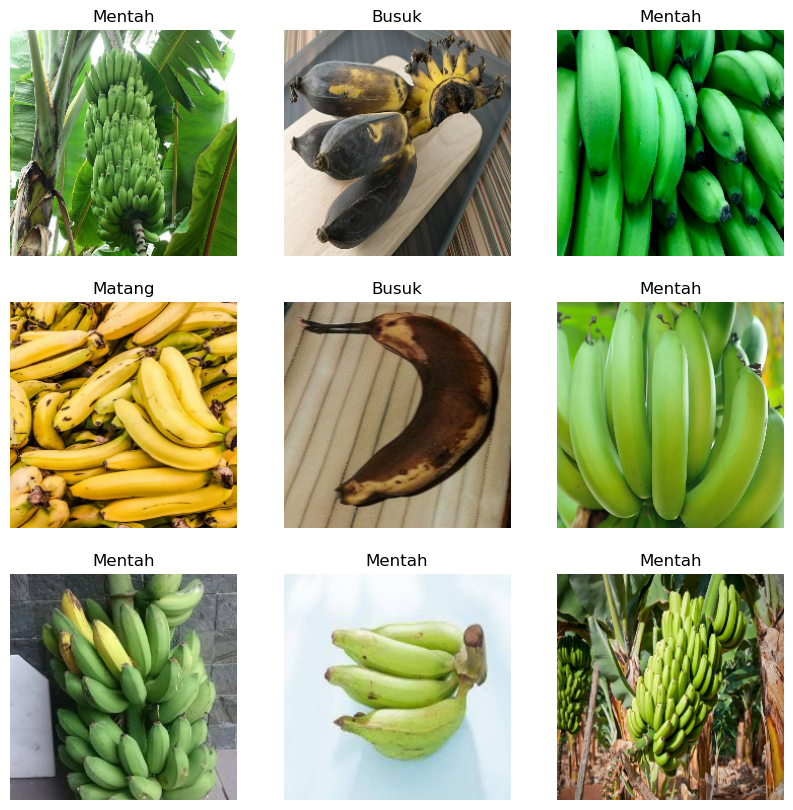

In [8]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10)) 


for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1) 
        plt.imshow(images[i].numpy().astype('uint8')) 
        plt.title(class_names[labels[i]]) 
        plt.axis('off') 

In [9]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)  


(10, 224, 224, 3)


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


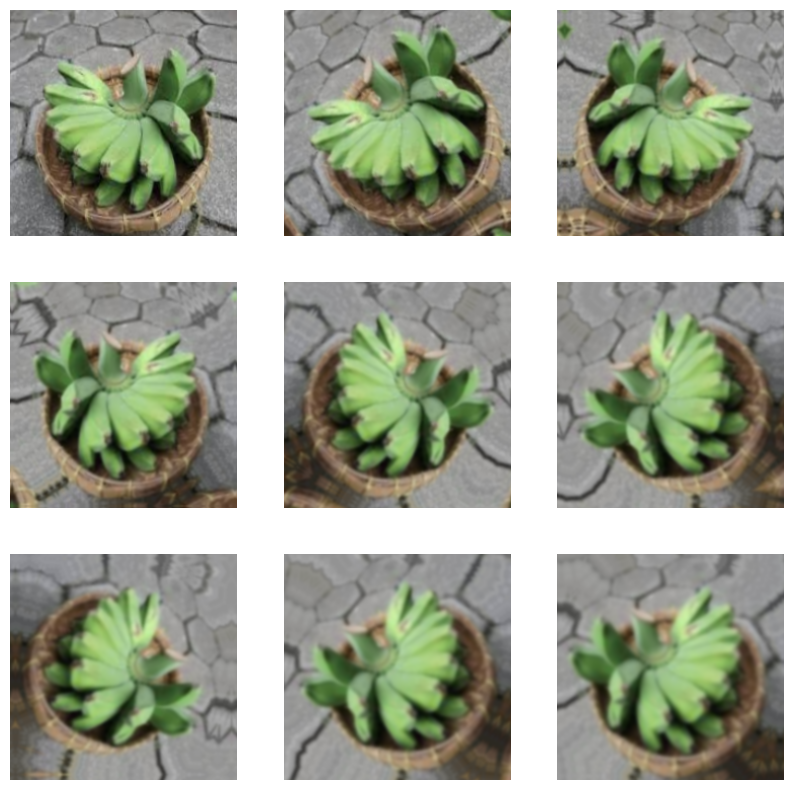

In [30]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

Tuner = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

i = 0
plt.figure(figsize=(10,10))
#Lihat data setelah di augmentasi
for images, labels in train_ds.take(69):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Rescaling, BatchNormalization

model = Sequential([
    data_augmentation,
    Rescaling(1./255, input_shape=(img_size, img_size, 3)),

    # Block 1 (Depthwise Separable Convolutions)
    SeparableConv2D(32, (3, 3), activation='relu', padding='same', strides=2),  # Reducing spatial dimensions early
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 2
    SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 3
    SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 4
    SeparableConv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 5
    SeparableConv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Global Average Pooling (instead of Flatten)
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Change this to sparse_categorical_crossentropy
              metrics=['accuracy'])


model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_15             │ (None, 112, 112, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_16             │ (None, 56, 56, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_17             │ (None, 28, 28, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_18             │ (None, 14, 14, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_19             │ (None, 7, 7, 512)      │       133,888 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 711,870 (2.72 MB)

 Trainable params: 709,886 (2.71 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [35]:

from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10, 
                               mode = 'max') 


history= model.fit(train_ds, 
                   epochs=30, 
                   validation_data=val_ds,  
                   callbacks=[early_stopping])

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.6609 - loss: 0.9871 - val_accuracy: 0.3200 - val_loss: 1.2131
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8284 - loss: 0.5420 - val_accuracy: 0.3200 - val_loss: 1.6220
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8920 - loss: 0.2907 - val_accuracy: 0.3200 - val_loss: 1.6797
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9365 - loss: 0.1687 - val_accuracy: 0.3200 - val_loss: 2.2364
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9597 - loss: 0.1238 - val_accuracy: 0.5500 - val_loss: 1.7207
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9535 - loss: 0.1376 - val_accuracy: 0.8600 - val_loss: 0.3359
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9375 - loss: 0.1699 - val_accuracy: 0.8500 - val_loss: 0.5708
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9355 - loss: 0.1799 - val_accuracy: 0.9400 - 

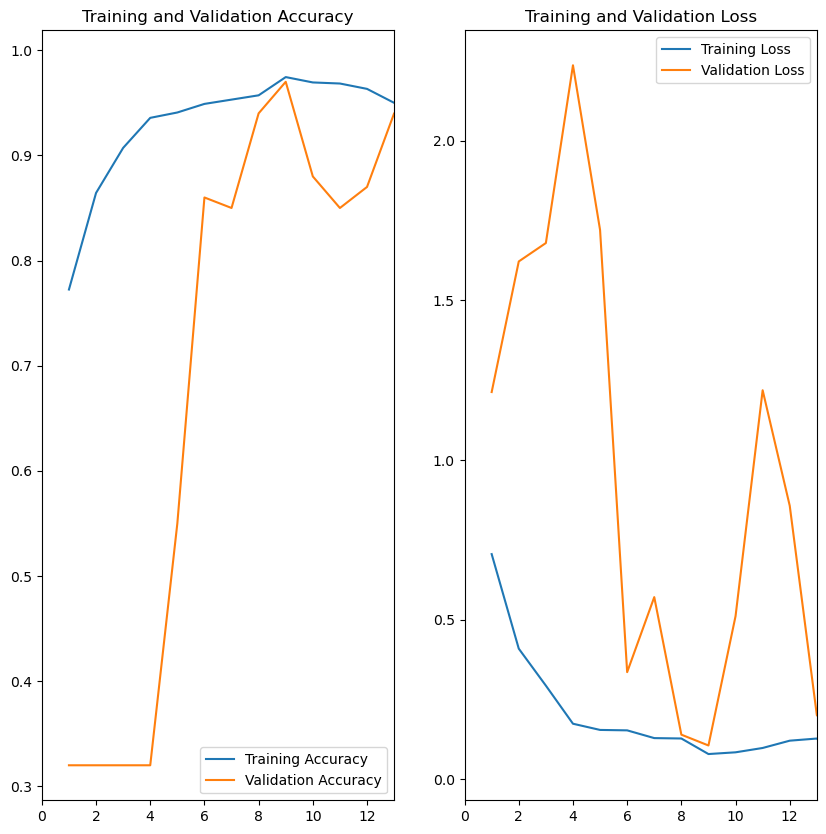

In [36]:

ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10)) 
plt.subplot(1, 2, 1) 
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.xlim(0, 13) 
plt.title('Training and Validation Accuracy') 


plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [37]:

model.save('model_mobilenet.h5')

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image


model = load_model(r'model_mobilenet.h5')  
class_names = ['Busuk', 'Matang', 'Mentah']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:

        input_image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0) 


        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"
result = classify_images(r'Prediksi\Matang\matang (8).jpg', save_path='matang.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
Prediksi: Matang
Confidence: 57.49%
Prediksi: Matang dengan confidence 57.49%. Gambar asli disimpan di matang.jpg.


Found 120 files belonging to 3 classes.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


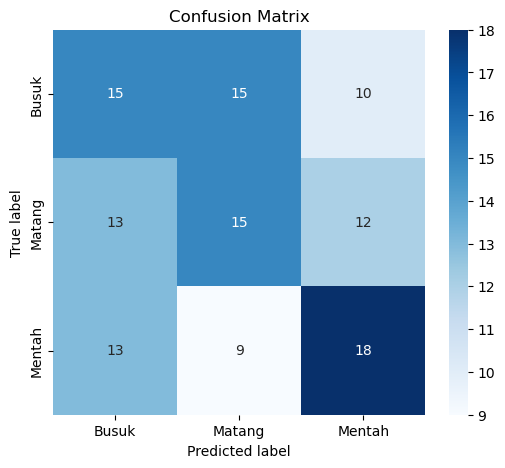

Confusion Matrix:
 [[15 15 10]
 [13 15 12]
 [13  9 18]]
Accuracy: 0.4
Precision: [0.36585366 0.38461538 0.45      ]
Recall: [0.375 0.375 0.45 ]
F1 Score: [0.37037037 0.37974684 0.45      ]


In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

# Muat data test yang sebenarnya
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data',
    labels='inferred',
    label_mode='categorical',  # Menghasilkan label dalam bentuk one-hot encoding
    batch_size=32,
    image_size=(224, 224)
)


y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  


true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy()) 
true_labels = tf.convert_to_tensor(true_labels)


conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)


f1_score = 2 * (precision * recall) / (precision + recall)


plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Busuk', 'Matang', 'Mentah'], yticklabels=['Busuk', 'Matang', 'Mentah'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print("Confusion Matrix:\n", conf_mat.numpy())
print("Accuracy:", accuracy.numpy())
print("Precision:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())